# Video Game Dataset (2020) Analysis - Nathan Nguyen

In [1]:
# import necessary packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.decomposition import PCA
import statsmodels.api as sm

from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy as sch

import copy

%matplotlib inline

In [2]:
pathDF = "/Users/nathannguyen/Desktop/21-22/Spring 22/CPSC392/Notebooks/Final_Project/video_game_dataset_2020/vgchartz-7_7_2020.csv"
gameDF = pd.read_csv(pathDF)

In [3]:
gameDF.drop("img", inplace=True, axis=1)
gameDF.drop("total_shipped", inplace=True, axis=1)
gameDF.drop("total_sales", inplace=True, axis=1)
gameDF.drop("release_date", inplace=True, axis=1)
gameDF.drop("last_update", inplace=True, axis=1)
gameDF.drop("Unnamed: 0", inplace=True, axis=1)

In [4]:
# Dropping Null
gameDF.dropna(inplace = True)
gameDF.reset_index(inplace = True)

# QUESTION 1

## Looking at the coefficients, which variables (of console, genre, vg score, critic score, user score) have the strongest relationship on North American sales?  

In [5]:
# Dummy Variables
gameDF = pd.get_dummies(gameDF, columns = ["console", "genre"]) # publisher and developer were removed

Diverging from my analysis plan and the original question, I removed the publisher and genre variables since I realized that by including them, my MSE and R2 scores for my model were extremely weird in that MSE had values in the thousands and R2 had values greater than 1 or smaller than -1. I did not know what exactly was causing this so I decided to remove them instead of figuring out a solution for the sake of time. I also did not go through with PCA with this question since the amount of rows after reducing the null values became extremely smaller and more managable that PCA was not needed. 

In [6]:
# Getting Predictors
predictors = list(gameDF.loc[:, gameDF.columns]) #https://stackoverflow.com/questions/29763620/how-to-select-all-columns-except-one-column-in-pandas
contin = ["vg_score", "critic_score", "user_score"]
predictors.remove("index")
predictors.remove("title")
predictors.remove("na_sales")
predictors.remove("publisher")
predictors.remove("developer")

X = gameDF[predictors]
y = gameDF["na_sales"]

# TTS
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 22)

# z score
z = StandardScaler()

z.fit(X_train[contin])
X_train[contin] = z.transform(X_train[contin])
X_test[contin] = z.transform(X_test[contin])

# create/fit model
LR = LinearRegression()
LR.fit(X_train,y_train)

# predictions
naSales_predTrain = LR.predict(X_train)
naSales_predTest = LR.predict(X_test)

# model performance
print("MSE Train:", np.round(mean_squared_error(y_train, LR.predict(X_train)), decimals = 4))
print("R2 Train:", np.round(r2_score(y_train, LR.predict(X_train)), decimals = 4))

print("MSE Test:", np.round(mean_squared_error(y_test, LR.predict(X_test)), decimals = 4))
print("R2 Test:", np.round(r2_score(y_test, LR.predict(X_test)), decimals = 4))

MSE Train: 0.6473
R2 Train: 0.7561
MSE Test: 0.4636
R2 Test: 0.5697


As we can see from the training and testing MSE and R2 scores, the model appears to be somewhat fit with moderate accuracy. The MSE scores for both train and test differ by 0.2 with MSE test being lower than MSE train. The model could be considered overfit, but I would say that in terms of this dataset's context, I would say this model is somewhat fit being on the verge of overfit since video game sales could fluctuate based off other factors not in this set, allowing this range of error to be acceptable. The R2 scores for train and test also reflect a similar pattern with R2 for test being approximately 0.2 lower than R2 for train. With an R2 score of 0.5697 for the testing set, the model has moderate accuracy, meaning it can accurately predict North American sales for video games a little more than half the time. Although definitely not the best model, it is better than barely predicting any accurate values.

In [7]:
# coefs
coefficients = pd.DataFrame({"Coef": LR.coef_,
                            "Names": predictors})
first_coef = coefficients.iloc[0:18]
second_coef = coefficients.iloc[18:37]

The coefficients dataframe was spilt in half into first_coef and second_coef since there were too many variables to fit onto one plot, thus making any graphs unreadable and unaccesible. 

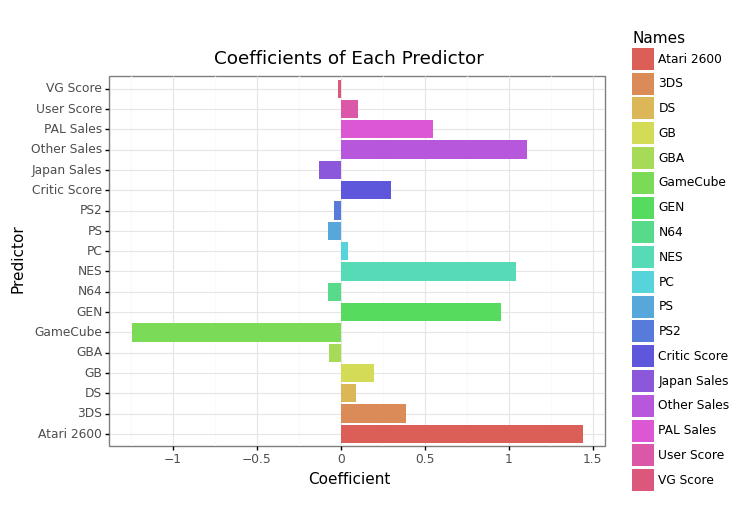

<ggplot: (8769446816013)>

In [8]:
# first coef plot
(ggplot(first_coef, aes(x = "Names", y = "Coef", fill = "Names" ))
 + theme_bw()
 + geom_bar(stat = "identity")
 + ggtitle('Coefficients of Each Predictor') 
 + xlab('Predictor') 
 + ylab('Coefficient')
 + coord_flip() # https://realpython.com/ggplot-python/#statistical-transformations-aggregate-and-transform-your-data
 + scale_fill_discrete(labels = ["Atari 2600", "3DS", "DS", "GB", "GBA", "GameCube", "GEN", "N64", "NES", "PC", "PS", "PS2", "Critic Score", "Japan Sales", "Other Sales", "PAL Sales", "User Score", "VG Score"]) # https://r-graphics.org/recipe-legend-label-text
 + scale_x_discrete(labels = ["Atari 2600", "3DS", "DS", "GB", "GBA", "GameCube", "GEN", "N64", "NES", "PC", "PS", "PS2", "Critic Score", "Japan Sales", "Other Sales", "PAL Sales", "User Score", "VG Score"]) )

As we can see from the first coef plot above, each of the predictors, including the dummied ones, is plotted with the value of their coefficient represented by the length of their repsective bar. The longest bar appears to be the Atari 2600 console with a value a little under 1.5. Without finding the maximum yet, I can intuitively say that the Atari 2600 is most likely the strongest predictor of North American sales since it has the longest bar. 

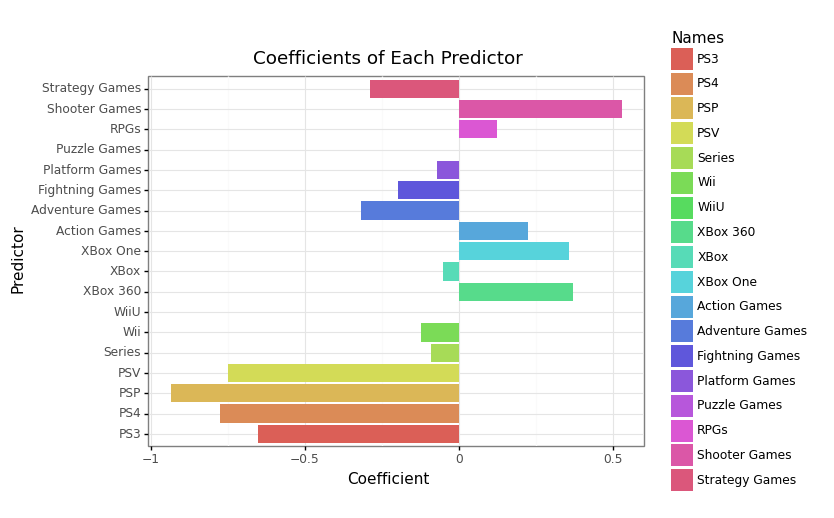

<ggplot: (8769446501184)>

In [9]:
# second coef plot
(ggplot(second_coef, aes(x = "Names", y = "Coef", fill = "Names" )) 
 + theme_bw()
 + geom_bar(stat = "identity")
 + ggtitle('Coefficients of Each Predictor') 
 + xlab('Predictor') 
 + ylab('Coefficient')
 + coord_flip()
 + scale_fill_discrete(labels = ["PS3", "PS4", "PSP", "PSV", "Series", "Wii", "WiiU", "XBox 360", "XBox", "XBox One", "Action Games", "Adventure Games", "Fightning Games", "Platform Games", "Puzzle Games", "RPGs", "Shooter Games", "Strategy Games"]) # https://r-graphics.org/recipe-legend-label-text
 + scale_x_discrete(labels = ["PS3", "PS4", "PSP", "PSV", "Series", "Wii", "WiiU", "XBox 360", "XBox", "XBox One", "Action Games", "Adventure Games", "Fightning Games", "Platform Games", "Puzzle Games", "RPGs", "Shooter Games", "Strategy Games"]) )

As with the first plot of coefficients, the second plot above shows the rest of the predictors and their respective coefficient value shown by the length of their bar. The largest coefficient on the plot above appears to be the PSP with a value a little over -1 (or a little under the absolute value of -1 which is 1). This value is still under the Atari 2600's value from the first plot, making it so the Atari 2600 is very likely the strongest predictor at this point without any calculations yet. 

In [10]:
# Getting max Coefficient
# The following was used as reference: https://www.adamsmith.haus/python/answers/how-to-convert-a-column-in-a-pandas-dataframe-to-a-numpy-array-in-python#:~:text=Call%20pandas.,it%20to%20a%20NumPy%20array.
coef_column = coefficients.loc[:,'Coef'] 

coefs = coef_column.values

coefs_abs = np.absolute(coefs)

maxCoef = np.amax(coefs_abs) # https://numpy.org/doc/stable/reference/generated/numpy.amax.html
print(f"The max coefficient is: {np.round(maxCoef, decimals = 4)}")

The max coefficient is: 1.4401


Looking at the coefficients, the dummied Atari 2600 console variable has the strongest relationship on North American sales with the largest coefficient of approximately 1.4401. In other words, this means that North American Sales is strongly dependent on whether or not the video game was released on the Atari 2600. This is a bit surprising since the Atari is a legacy console that has not had a new video game release on it in decades, making me question why specifically this console has such a large effect on North American sales. It is possible that since I dropped any values with null values, the remaining elements were unbalanced, thus leaving out some video games that could have made a bigger impact and change which variable would have the strongest effect on North American sales. In the future, another data could be used to compare the results. 

# QUESTION 2

## When considering critic score, user score, and north american sales, what clusters emerge and what characterize those clusters?   


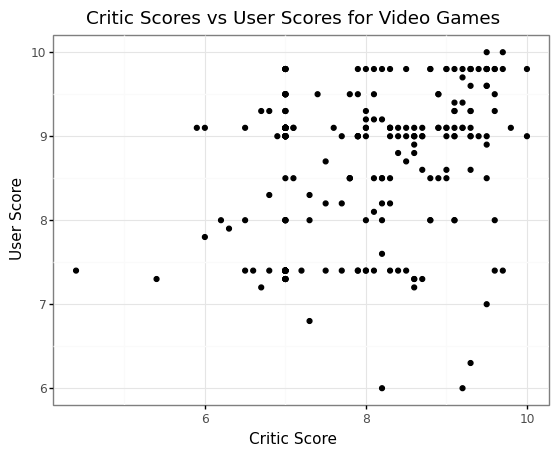

<ggplot: (8769436658520)>

In [11]:
# Critic Score vs User Score
(ggplot(gameDF, aes(x="critic_score", y = "user_score")) 
 + geom_point() 
 + theme_bw()
 + labs(x = "Critic Score",
       y = "User Score",
       title = "Critic Scores vs User Scores for Video Games"))

This data points appears to have random variance that is neither spherical or elliptical. Points also appears very close to each other but there are also noticeable noise points. 

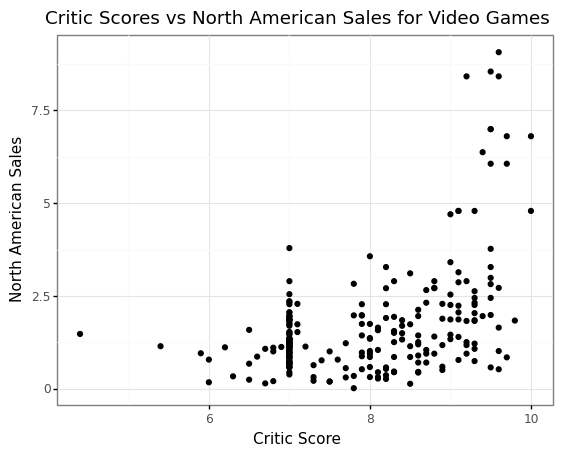

<ggplot: (8769446594347)>

In [12]:
# Critic Score vs North American Sales
(ggplot(gameDF, aes(x="critic_score", y = "na_sales")) 
 + geom_point() 
 + theme_bw()
 + labs(x = "Critic Score",
       y = "North American Sales",
       title = "Critic Scores vs North American Sales for Video Games"))

As with the first plot, the points appears to not have spherical or elliptical variance, but noise points are noticeable.

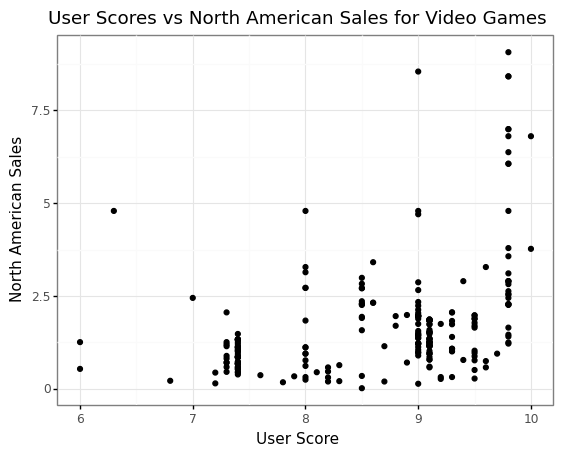

<ggplot: (8769443773447)>

In [13]:
# User Score vs North American Sales
(ggplot(gameDF, aes(x="user_score", y = "na_sales")) 
 + geom_point() 
 + theme_bw()
 + labs(x = "User Score",
       y = "North American Sales",
       title = "User Scores vs North American Sales for Video Games"))

As with the first two plots, this third plot has points that are neither spherical or elliptical in shape, but noise points are noticeable. 

The DBSCAN model does not make any assumptions about the shape of the clusters. DBSCAN is recommended to use for data with noise since it can detect noise points easily. I believe DBSCAN is the best since the dataset has noticeable noise points, a quality that make DBSCAN good for clustering, and since KMEANS and Gaussian Mixture Models would do poorly with this dataset. 

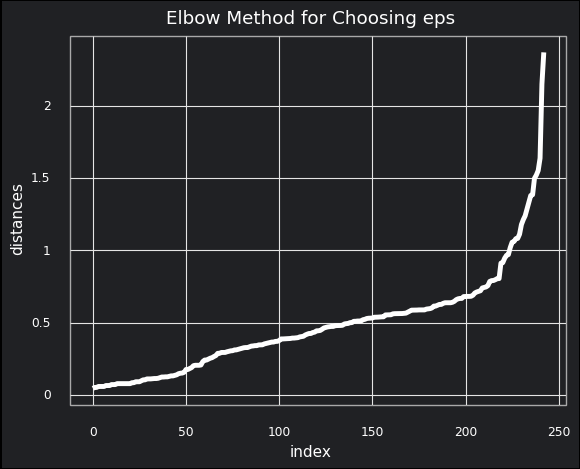

<ggplot: (8769443733712)>

In [14]:
# Finding best EPS using Elbow Method 
# Reference for choosing MinPts: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

gameDF2 = copy.deepcopy(gameDF) # https://www.geeksforgeeks.org/copy-python-deep-copy-shallow-copy/

z2 = StandardScaler()

variables = ["critic_score", "user_score", "na_sales"]

gameDF2[variables] = z2.fit_transform(gameDF2[variables])

mins = 6 # We are using three variables, so 2 * 3 = 6

nn = NearestNeighbors(n_neighbors = mins + 1)

nn.fit(gameDF2[variables])

distances, neighbors = nn.kneighbors(gameDF2[variables])

distances = np.sort(distances[:, mins], axis = 0)

distances_df = pd.DataFrame({"distances": distances,
                             "index": list(range(0,len(distances)))})

epPlt = (ggplot(distances_df, aes(x = "index", y = "distances")) +
 geom_line(color = "white", size = 2) + theme_minimal() +
 labs(title = "Elbow Method for Choosing eps") +
 theme(panel_grid_minor = element_blank(),
      rect = element_rect(fill = "#202124ff"),
      axis_text = element_text(color = "white"),
      axis_title = element_text(color = "white"),
      plot_title = element_text(color = "white"),
      panel_border = element_line(color = "darkgray"),
      plot_background = element_rect(fill = "#202124ff")
      ))
epPlt


Based off the plot for the elbow method above, the inflection point or "elbow" appears to be around 0.75. Hence, I chose 0.75 as my epsilon value for my DBSCAN model. 

In [15]:
# Creating Model with eps = 0.75
dbMod = DBSCAN(eps = 0.75, min_samples = 6).fit(gameDF2[variables])

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(dbMod.labels_)))]

gameDF2["assignments"] = dbMod.labels_

In [16]:
# Silhouette Score for DBSCAN
game_clustered = gameDF2.loc[(gameDF2.assignments >= 0)]

s1 = silhouette_score(game_clustered[["critic_score","user_score"]], game_clustered["assignments"])
s2 = silhouette_score(game_clustered[["critic_score","na_sales"]], game_clustered["assignments"])
s3 = silhouette_score(game_clustered[["user_score","na_sales"]], game_clustered["assignments"])

print(f"SS for Critic Score v. User Score: {np.round(s1, decimals = 4)}")
print(f"SS for Critic Score v. North American Sales: {np.round(s2, decimals = 4)}")
print(f"SS for User Score v. North American Sales: {np.round(s3, decimals = 4)}")

avgSS = (s1 + s2 + s3) / 3

print(f"Average SS: {np.round(avgSS, decimals = 4)}")

SS for Critic Score v. User Score: 0.2075
SS for Critic Score v. North American Sales: 0.6587
SS for User Score v. North American Sales: 0.6525
Average SS: 0.5062


The average silhouette score for each of the three graphs using the DBSCAN model is approximately 0.5062. A higher silhouette score means a better fit clustering model, but a silhouette score of 0.5 means that my DBSCAN model is not the best but also not the worse for this dataset. The first graph of critic and user score individually has the lowest score of 0.2075, meaning these clusters will be the ones that are not really fit at all, but the other two plots should be mostly fit and clustered well. 

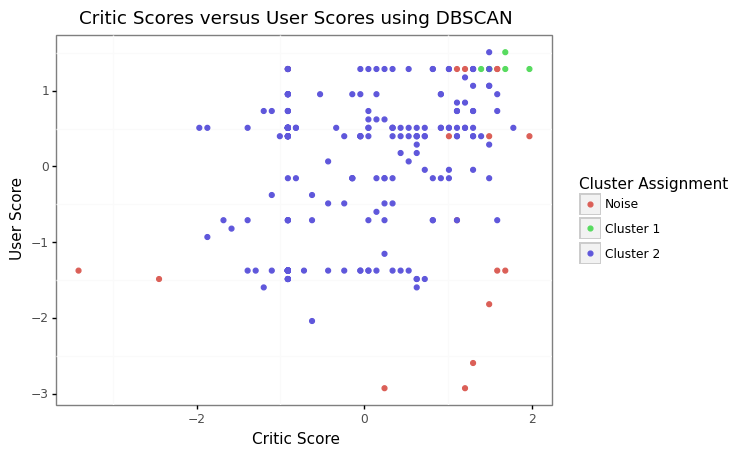

<ggplot: (8769443773693)>

In [17]:
# Critic Score vs User Score using DBSCAN
(ggplot(gameDF2, aes(x = "critic_score", y = "user_score", color = "factor(assignments)")) +
 geom_point() +
 theme_bw() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(x = "Critic Score",
     y = "User Score",
    title = "Critic Scores versus User Scores using DBSCAN"))

From the plot above, cluster one appears to be games that are very popular with everyone and critic alike while cluster two appears to be games that are somewhat popular with critics but more popular with everyone. However, as evidence by its silhouette score, the clusters for this plot are not fit very well using my model so the true clusters for there groups may be different. 

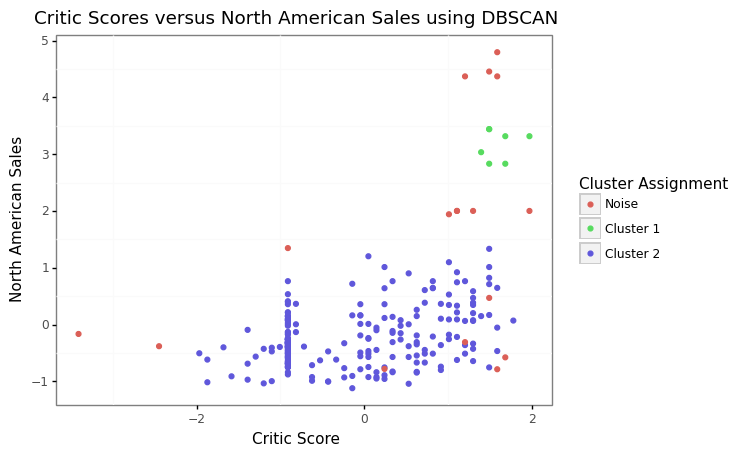

<ggplot: (8769443922884)>

In [18]:
# Critic Score vs North American Sales using DBSCAN
(ggplot(gameDF2, aes(x = "critic_score", y = "na_sales", color = "factor(assignments)")) +
 geom_point() +
 theme_bw() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(x = "Critic Score",
     y = "North American Sales",
    title = "Critic Scores versus North American Sales using DBSCAN"))

From the second plot above, cluster one appears to be games that are very popular with critics and had high sales in North America. In contrast, cluster two appears to be games that are somewhat popular with critics and had average to somewhat high sales. 

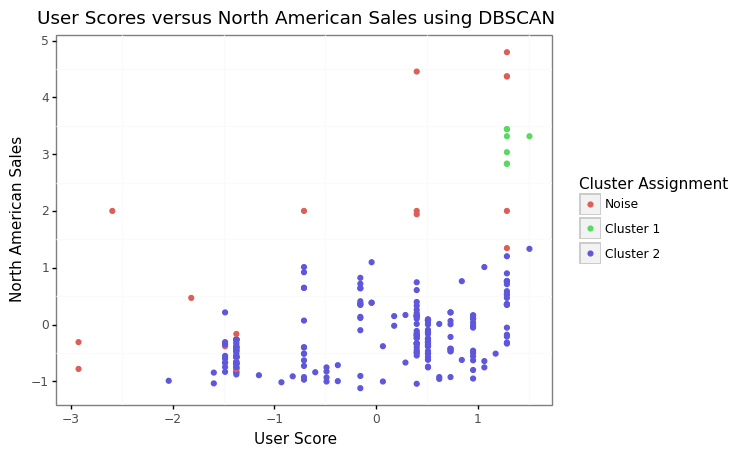

<ggplot: (8769446818070)>

In [19]:
# User Score vs North American Sales using DBSCAN
(ggplot(gameDF2, aes(x = "user_score", y = "na_sales", color = "factor(assignments)")) +
 geom_point() +
 theme_bw() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(x = "User Score",
     y = "North American Sales",
    title = "User Scores versus North American Sales using DBSCAN"))

From the third plot above, cluster one appears to be games that are very popular with general audiences and had high sales in North America. Cluster two, however, appears to be games that are more popular with general audiences but had average to somewhat high sales.



When considering critic score, user score, and north american sales, the following clusters emerge:

The first plot of critic and user scores show that user and critic scores are fairly similar and in the same cluster. However due to its silhouette score, the data points do not really fit in their clusters so these clusters may not really be valid which makes sense since critic scores should intuitively be lower than audience scores.

For the other two plots, silhouette scores were above 0.5 so their clusters should more accurately potray a reaslitic trend.

The second plot of critic scores and sales show that higher critic scores and higher North American sales are clustered together. This means the trend is that lower critic scores have lower sales while higher critic scores have higher sales. 

The third plot of user scores and sales show that higher user scores and higher North American sales are clustered together. In the same trend as the second plot, lower user scores have lower sales while higher user scores have higher sales. 

The trends for the second and third plot logically make sense. Realistically, if the general audience and critic highly enjoyed a game, then sales should be higher for that game, which is shown in the clusters from my model. This would be useful for a company who wish to see trends in critic and user scores and sales for their game.

# QUESTION 3

## When comparing a model using PCA on all the continuous variables(except critic score) in the dataset and retaining enough PCs to keep 85% of the variance, to a model using all the continuous variables(except critic score), how much of a difference is there in mean squared error and R2 score when predicting critic score?  

Diverging from the analysis plan, I also decided to compared R2 scores between the linear regression and PCA model since R2 represents accuracy and we can determine of accuracy differs for both models depending on whether or not it uses PCA.

In [21]:
# Making a copy of the dataset to avoid issues with double z-scoring
gameDF3 = copy.deepcopy(gameDF) # https://www.geeksforgeeks.org/copy-python-deep-copy-shallow-copy/

predictors3 = ["vg_score", "user_score", "na_sales", "jp_sales", "pal_sales", "other_sales"]

# TTS
X_train3, X_test3, y_train3, y_test3 = train_test_split(gameDF3[predictors3],gameDF3["critic_score"], test_size = 0.2, random_state = 22)

# Z Score
z3 = StandardScaler()

gameDF3[predictors3] = z3.fit_transform(gameDF3[predictors3])

# Linear Regression Model
lrmod = LinearRegression()

lrmod.fit(X_train3, y_train3)

# Predictions
y_pred = lrmod.predict(X_test3)

# Training R2
trainR2 = r2_score(y_train3, lrmod.predict(X_train3))
print(f"Training R2: {np.round(trainR2, decimals = 4)}")

# Testing R2
testR2 = r2_score(y_test3, lrmod.predict(X_test3))
print(f"Test R2: {np.round(testR2, decimals = 4)}")

# Train MSE
mseTrain = mean_squared_error(y_train3, lrmod.predict(X_train3))
print(f"Train MSE: {np.round(mseTrain, decimals = 4)}")

# Test MSE
mseTest = mean_squared_error(y_test3, lrmod.predict(X_test3))
print(f"Test MSE: {np.round(mseTest, decimals = 4)}")


Training R2: 0.3261
Test R2: 0.3155
Train MSE: 0.6602
Test MSE: 1.0135


For the linear regression model without PCA, the training and testing scores for R2 appears to be extremely similar while for MSE they seem to be off but by only approximately 0.4. The similar R2 scores mean that, although low, the accuracy of the model is the same for both datasets. The MSE for both sets however differ by a small amount and I would say that the model is still fit and not overfit since the MSE is only off by 0.4 and not a larger value. 

In [22]:
pca = PCA()
pca.fit(gameDF3[predictors3])

pcaDF = pd.DataFrame({"expl_var" :
                      pca.explained_variance_ratio_,
                      "pc": range(1,7),
                      "cum_var":
                      pca.explained_variance_ratio_.cumsum()})

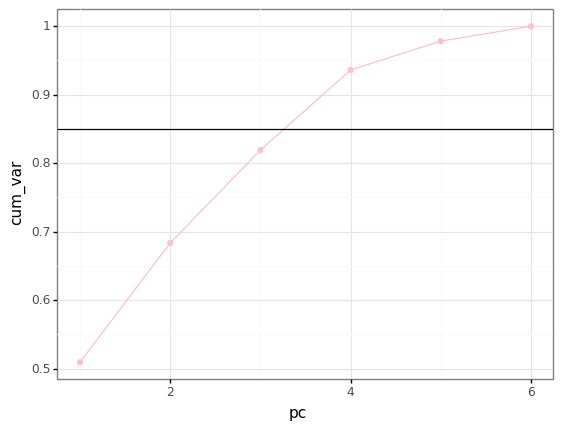

<ggplot: (8769442202649)>

In [23]:
(ggplot(pcaDF, aes(x = "pc", y = "cum_var")) 
 + geom_line(color = "pink") 
 + geom_point(color = "pink") 
 + geom_hline(yintercept = 0.85)
 + theme_bw())

From the scree plot above, we can see that there are three principle components under the line plotted at y = 0.85 representing the amount of variance we want. Therefore, three principle components will be used for the PCA model. 

In [24]:
pcomps3 = pca.transform(gameDF3[predictors3])
pcomps3 = pd.DataFrame(pcomps3[:, 0:3])

# TTS
X_train4, X_test4, y_train4, y_test4 = train_test_split(pcomps3,gameDF3["critic_score"], test_size = 0.2, random_state = 22)

# Z Score
z4 = StandardScaler()

pcomps3 = z4.fit_transform(pcomps3)

# Linear Regression Model
lrmod2 = LinearRegression()

lrmod2.fit(X_train4, y_train4)

# Predictions
y_pred2 = lrmod2.predict(X_test4)

# Training R2
trainR22 = r2_score(y_train4, lrmod2.predict(X_train4))
print(f"Training R2: {np.round(trainR22, decimals = 4)}")

# Testing R2
testR22 = r2_score(y_test4, lrmod2.predict(X_test4))
print(f"Test R2: {np.round(testR22, decimals = 4)}")

# Train MSE
mseTrain2 = mean_squared_error(y_train4, lrmod2.predict(X_train4))
print(f"Train MSE: {np.round(mseTrain2, decimals = 4)}")

# Test MSE
mseTest2 = mean_squared_error(y_test4, lrmod2.predict(X_test4))
print(f"Test MSE: {np.round(mseTest2, decimals = 4)}")

Training R2: 0.2864
Test R2: 0.3209
Train MSE: 0.6991
Test MSE: 1.0055


For the linear regression model with PCA, the training and testing scores for R2 appears to be similar while for MSE they seem to be off but by only approximately 0.3. The similar R2 scores mean that, although low like for the original model, the accuracy of the PCA model is overall the same for both datasets. The MSE for both sets however differ by a small amount and I would say that the model is still fit and not overfit since the MSE is only off by 0.3 and not a larger value. 

In [25]:
toDF2 = [["linearTrain", mseTrain, trainR2], ["pcaTrain", mseTrain2, trainR22], ["linearTest", mseTest, testR2], ["pcaTest", mseTest2, testR22]]

scoreDF = pd.DataFrame(toDF2, columns = ["TITLE", "MSE", "R2"])
scoreDF["round1"] = np.round(scoreDF["MSE"], decimals = 4)
scoreDF["round2"] = np.round(scoreDF["R2"], decimals = 4)


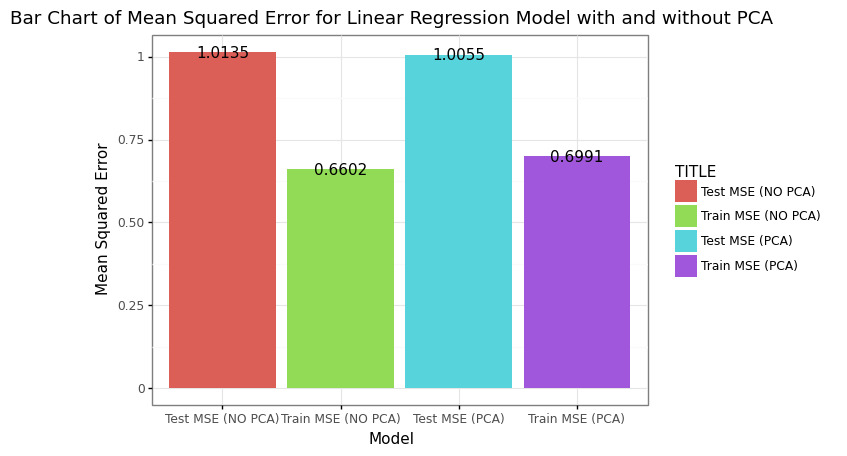

<ggplot: (8769446811013)>

In [26]:
(ggplot(scoreDF, aes(x = "TITLE", y = "MSE", fill = "TITLE")) 
    + geom_bar(stat = "identity") 
    + theme_bw()
    + geom_text(aes(label = "round1")) # https://www.r-bloggers.com/2021/09/adding-text-labels-to-ggplot2-bar-chart/
    + labs(x = "Model",
          y = "Mean Squared Error",
          title = "Bar Chart of Mean Squared Error for Linear Regression Model with and without PCA"
          )
    + scale_fill_discrete(labels = ["Test MSE (NO PCA)", "Train MSE (NO PCA)", "Test MSE (PCA)", "Train MSE (PCA)"]) # https://r-graphics.org/recipe-legend-label-text
    + scale_x_discrete(labels = ["Test MSE (NO PCA)", "Train MSE (NO PCA)", "Test MSE (PCA)", "Train MSE (PCA)"]) 
)

As shown in the plot above, when comparing a model using PCA on all the continuous variables(except critic score) in the dataset and retaining enough PCs to keep 85% of the variance, to a model using all the continuous variables(except critic score),there is a small difference (~0.1 - ~0.3) in mean squared error when predicting critic score.

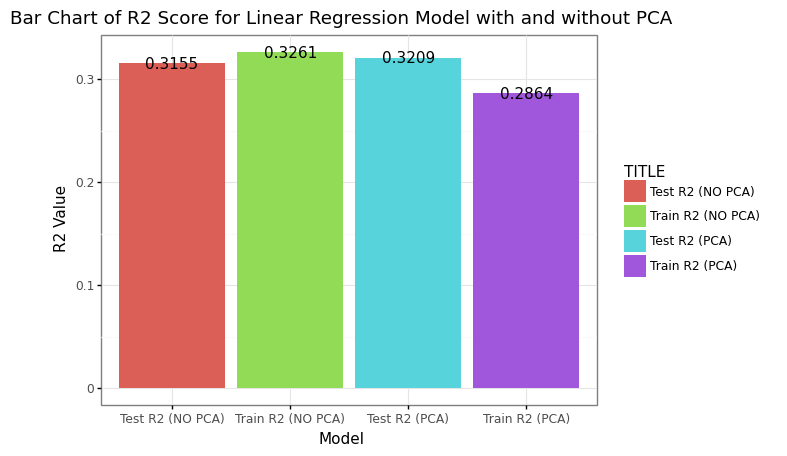

<ggplot: (8769443768682)>

In [27]:
(ggplot(scoreDF, aes(x = "TITLE", y = "R2", fill = "TITLE")) 
    + geom_bar(stat = "identity") 
    + theme_bw()
    + geom_text(aes(label = "round2")) # https://www.r-bloggers.com/2021/09/adding-text-labels-to-ggplot2-bar-chart/
    + labs(x = "Model",
          y = "R2 Value",
          title = "Bar Chart of R2 Score for Linear Regression Model with and without PCA"
          )
    + scale_fill_discrete(labels = ["Test R2 (NO PCA)", "Train R2 (NO PCA)", "Test R2 (PCA)", "Train R2 (PCA)"]) # https://r-graphics.org/recipe-legend-label-text
    + scale_x_discrete(labels = ["Test R2 (NO PCA)", "Train R2 (NO PCA)", "Test R2 (PCA)", "Train R2 (PCA)"]) 
)

Similarly to mean squared error, the bar plot above shows that when comparing a model using PCA on all the continuous variables(except critic score) in the dataset and retaining enough PCs to keep 85% of the variance, to a model using all the continuous variables(except critic score),there is a small difference (~0.1) in R2 score when predicting critic score.

Therefore, since there is only a miniscule difference in R2 and mean squared error between the original linear regression model and the PCA model, the PCA method would be effective if one desired to utilize it to reduce the dimensions of this dataset. This would be useful if a company would like to predict critic scores of a video game but the dataset is too large to efficiently analyze using a model.